In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mdtraj as md
import gc

In [3]:
def load_log(file: str) -> pd.DataFrame:
    """Load a log file into a pandas DataFrame, cleaning column names."""
    # The file is tab-separated; standard CSV parsing fails without sep='\t'
    df = pd.read_csv(file, sep='\t')
    
    # Clean artifacts and whitespace from column names
    df.columns = df.columns.str.replace('#', '').str.replace('"', '').str.strip()
    return df


def load_dcd(dcd_file: str, top: str) -> md.Trajectory:
    """Load a DCD trajectory file with a given topology."""
    traj = md.load_dcd(dcd_file, top=top)
    return traj


def load_pdb(pdb_file: str) -> md.Trajectory:
    """Load a PDB file into an mdtraj Trajectory."""
    traj = md.load_pdb(pdb_file)
    return traj


def plot_parameter(
    df: pd.DataFrame,
    x: str,
    y: str,
) -> None:
    """
    Plot a parameter from the DataFrame.

    Parameters
    ----------
    df : pd.DataFrame
        DataFrame containing the log data.
    x : str
        Column name for the x-axis.
    y : str
        Column name for the y-axis.

    Returns
    -------
    None
    """
    sns.set_theme(style="whitegrid", context="paper")

    plt.figure(figsize=(16, 6))
    sns.lineplot(data=df, x=x, y=y)
    plt.title(f"{y} over {x}", fontsize=16)
    plt.xlabel(x)
    plt.ylabel(y)
    plt.grid(True)

    plt.show()


def plot_rmsd(
    traj: md.Trajectory,
    ref_pdb: md.Trajectory,
    minimized_pdb: md.Trajectory,
    equilibrated_pdb: md.Trajectory,
    backbone: list,
    time: np.ndarray,
) -> None:
    """
    Plot RMSD of the trajectory against reference, minimized, and equilibrated
    structures.
    """
    # 1. RMSD vs Crystal (Ref)
    # We must select backbone indices specifically for the ref_pdb topology
    # because it likely differs from the trajectory topology (e.g., no solvent).
    ref_backbone = ref_pdb.topology.select("backbone")

    # validation: Atom counts must match for RMSD calculation
    if len(backbone) == len(ref_backbone):
        rmsd_crystal = md.rmsd(
            traj,
            ref_pdb,
            atom_indices=backbone,       # Indices in trajectory
            ref_atom_indices=ref_backbone # Indices in reference
        )
    else:
        print(f"Warning: Atom count mismatch (Traj: {len(backbone)}, Ref: {len(ref_backbone)}). Skipping Crystal RMSD.")
        rmsd_crystal = np.zeros(len(traj))

    # 2. RMSD vs Minimized
    # Minimized/Equilibrated usually share topology with production traj
    rmsd_minim = md.rmsd(
        traj,
        minimized_pdb,
        atom_indices=backbone
    )

    # 3. RMSD vs Equilibrated
    rmsd_equil = md.rmsd(
        traj,
        equilibrated_pdb,
        atom_indices=backbone
    )

    # Plotting
    sns.set(style="whitegrid", context="talk")
    plt.figure(figsize=(16, 8))

    # Equilibrated
    sns.scatterplot(x=time, y=rmsd_equil, s=35, color="gray", alpha=0.4, label="Ref: Equilibrated")
    sns.lineplot(x=time[5:-5], y=np.convolve(rmsd_equil, np.ones(5)/5, mode="same")[5:-5], color="gray")

    # Minimized
    sns.scatterplot(x=time, y=rmsd_minim, s=35, color="blue", alpha=0.4, label="Ref: Minimized")
    sns.lineplot(x=time[5:-5], y=np.convolve(rmsd_minim, np.ones(5)/5, mode="same")[5:-5], color="blue")

    # Crystal (Only plot if calculation succeeded)
    if np.any(rmsd_crystal):
        sns.scatterplot(x=time, y=rmsd_crystal, s=35, color="red", alpha=0.4, label="Ref: Initial")
        sns.lineplot(x=time[5:-5], y=np.convolve(rmsd_crystal, np.ones(5)/5, mode="same")[5:-5], color="red")

    plt.xlabel("Time (ns)")
    plt.ylabel("RMSD (nm)")
    plt.title("RMSD, Backbone")
    plt.legend()
    plt.tight_layout()
    plt.show()


def plot_rog(
    traj: md.Trajectory,
    time: np.ndarray,
) -> None:
    """
    Plot Radius of Gyration over time.

    Parameters
    ----------
    traj : md.Trajectory
        The trajectory to analyze.
    time : np.ndarray
        Array of time points corresponding to the trajectory frames.

    Returns
    -------
    None
    """
    rog = md.compute_rg(traj)

    sns.set(style="whitegrid", context="talk")
    plt.figure(figsize=(16, 8))

    sns.scatterplot(
        x=time,
        y=rog,
        s=35,
        color="gray",
        alpha=0.4,
        label="Radius of Gyration"
    )
    sns.lineplot(
        x=time[5: -5],
        y=np.convolve(rog, np.ones(5)/5, mode="same")[5: -5],
        color="gray"
    )
    plt.xlabel("Time (ns)")
    plt.ylabel("Radius of Gyration (nm)")
    plt.title("Radius of Gyration")
    plt.legend()
    plt.tight_layout()
    plt.show()


def plot_dssp(
    traj: md.Trajectory,
    time: np.ndarray
) -> None:
    """
    Plot secondary structure elements over time using DSSP.

    Parameters
    ----------
    traj : md.Trajectory
        The trajectory to analyze.
    time : np.ndarray
        Array of time points corresponding to the trajectory frames.

    Returns
    -------
    None
    """
    ss_map = {
        "H": "Alpha helix",
        "B": "Residue in isolated beta-bridge",
        "E": "Extended strand, participates in beta ladder",
        "G": "3-helix (3/10 helix)",
        "I": "5 helix (pi helix)",
        "T": "Hydrogen bonded turn",
        "S": "Bend",
        " ": "Loops and irregular elements",
    }
    colors = {
        "H": "brown",
        "B": "mediumblue",
        "E": "magenta",
        "G": "green",
        "I": "orange",
        "T": "navy",
        "S": "purple",
        " ": "gray",
    }

    dssp = md.compute_dssp(traj, simplified=False)

    dssp_df = pd.DataFrame(
        columns=ss_map.keys(),
        index=time
    )

    for i in range(dssp.shape[0]):
        ss, counts = np.unique(dssp[i, :], return_counts=True)
        for s, c in zip(ss, counts):
            dssp_df.at[time[i], s] = c

    sns.set(style="whitegrid", context="talk")
    plt.figure(figsize=(18, 10))

    for col in dssp_df.columns:
        if col == "NA":
            continue
        sns.scatterplot(
            data=dssp_df,
            x=dssp_df.index,
            y=col,
            alpha=0.4,
            s=35,
            label=ss_map[col],
            color=colors[col]
        )
        sns.lineplot(
            x=dssp_df.index[5: -5],
            y=np.convolve(
                dssp_df[col].fillna(0), np.ones(5)/5, mode="same"
            )[5: -5],
            color=colors[col],
        )
    plt.xlabel("Time (ns)")
    plt.ylabel("Number of Residues")
    plt.title("Secondary Structure Elements over Time")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', prop={"size": 12})
    plt.tight_layout()
    plt.show()


def analysis(
    name: str,
    time_scale: float = 0.01,
) -> None:
    """Full analysis pipeline for a given simulation setup."""
    # Production output name
    output_name = name + "_production"

    # --- Load Log Files ---
    # The simulation saves production data to <name>_production.log
    # Load production log for production plots
    md_log = load_log(f"{output_name}.log") # CORRECTED FILENAME

    # --- Load Trajectory Files ---
    # The initial crystal structure
    ref_pdb = load_pdb(
        f"{name}.pdb"
    )
    # The minimized structure is used as the topology for the DCD, and a reference
    minimized_pdb = load_pdb(
        f"{name}_minimized.pdb"
    )
    # The equilibrated structure is used as a reference
    equilibrated_pdb = load_pdb(
        f"{name}_equilibrated.pdb"
    )
    # The DCD file is saved as <name>_production.dcd
    # The topology for the DCD must be the minimized structure (or equilibrated/initial PDB)
    # The simulation uses the minimized PDB as the basis for the DCD topology.
    traj = load_dcd(
        f"{output_name}.dcd", # CORRECTED FILENAME
        top=f"{name}_minimized.pdb"
    )

    # --- Prepare Data for Analysis ---
    backbone = traj.topology.select("backbone")
    # Production time = 1 ns, report time = 10 ps, trajectory time = 10 ps
    # Timestep = 2 fs
    # Trajectory_steps = trajectory_time / timestep = 10 ps / 2 fs = 5000 steps
    # time_scale is the time between trajectory frames in nanoseconds.
    # Time between frames is trajectory_time (10 ps = 0.01 ns).
    time = np.arange(len(traj)) * time_scale

    # --- Plot Log Parameters (from Production Log Only) ---
    print("Plotting Production Log Data...")
    # NOTE: The plot_parameter function logic for split_equil_step is now obsolete
    # for the production log, as this log only contains production data.
    # The split_equil_step parameter has been removed from the function call.
    plot_parameter(
        md_log,
        "Step",
        "Potential Energy (kJ/mole)",
        # split_equil_step=split_equil_step # Removed
    )
    plot_parameter(
        md_log,
        "Step",
        "Kinetic Energy (kJ/mole)",
        # split_equil_step=split_equil_step # Removed
    )
    plot_parameter(
        md_log,
        "Step",
        "Total Energy (kJ/mole)",
        # split_equil_step=split_equil_step # Removed
    )
    plot_parameter(
        md_log,
        "Step",
        "Temperature (K)",
        # split_equil_step=split_equil_step # Removed
    )

    # --- Plot Trajectory Metrics ---
    print("Plotting Trajectory Metrics...")
    plot_rmsd(traj, ref_pdb, minimized_pdb, equilibrated_pdb, backbone, time)

    plot_rog(traj, time)

    plot_dssp(traj, time)

    # --- Memory Cleanup ---
    # Note: 'minim' variable is not defined in the provided code, removed from del.
    del traj, ref_pdb, minimized_pdb, equilibrated_pdb, md_log
    plt.close("all")
    gc.collect()

dcdplugin) detected standard 32-bit DCD file of native endianness
dcdplugin) CHARMM format DCD file (also NAMD 2.1 and later)
Plotting Production Log Data...


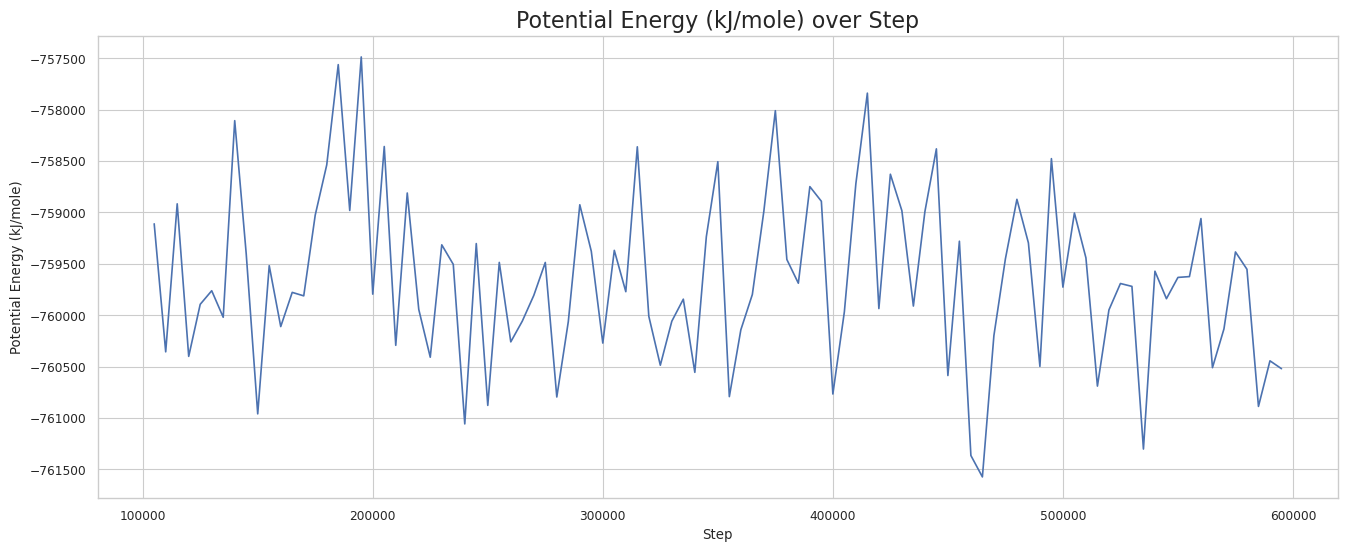

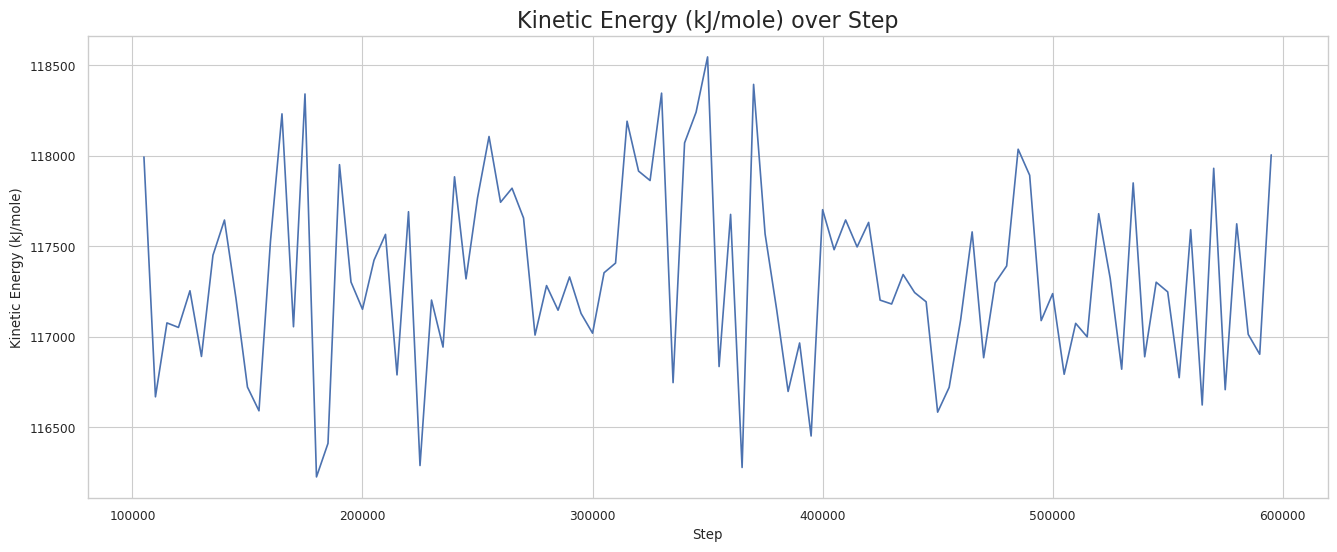

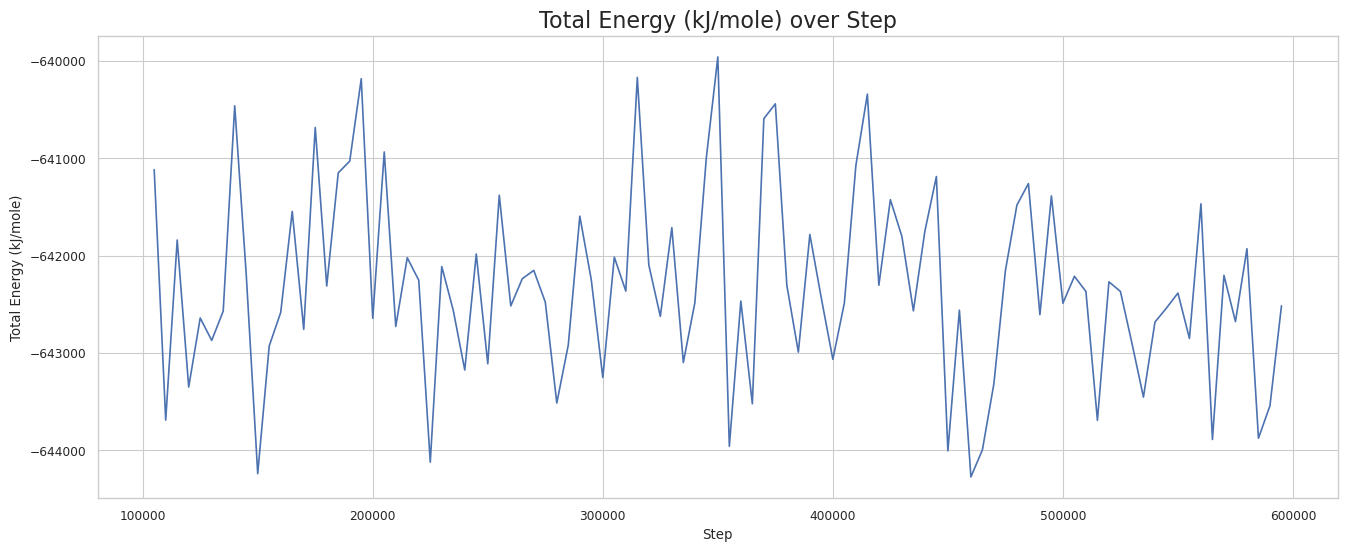

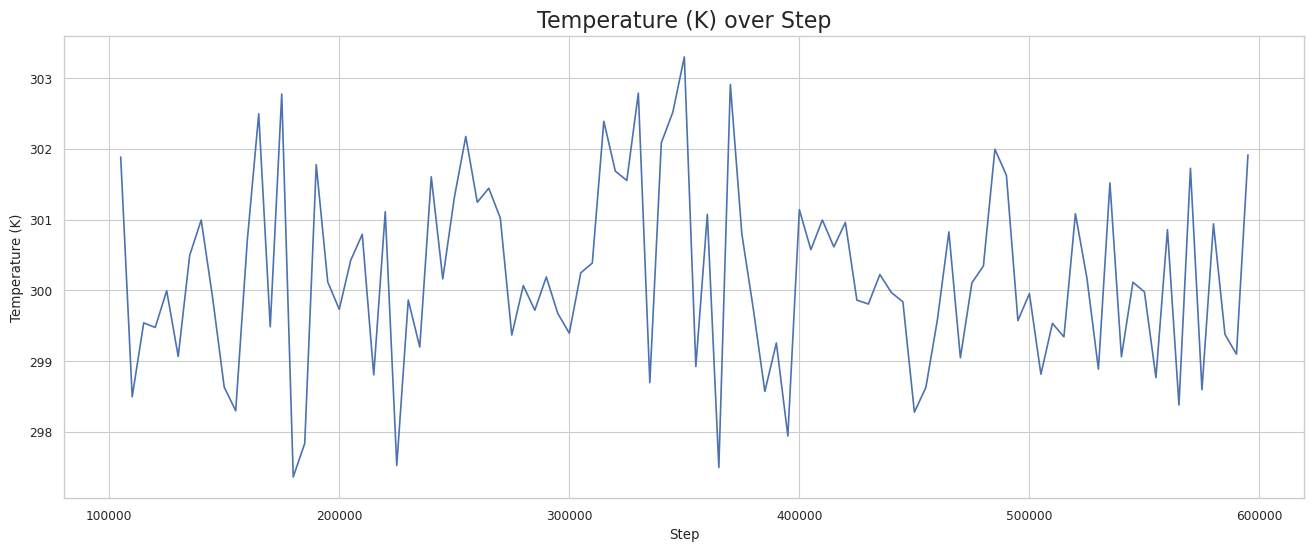

Plotting Trajectory Metrics...


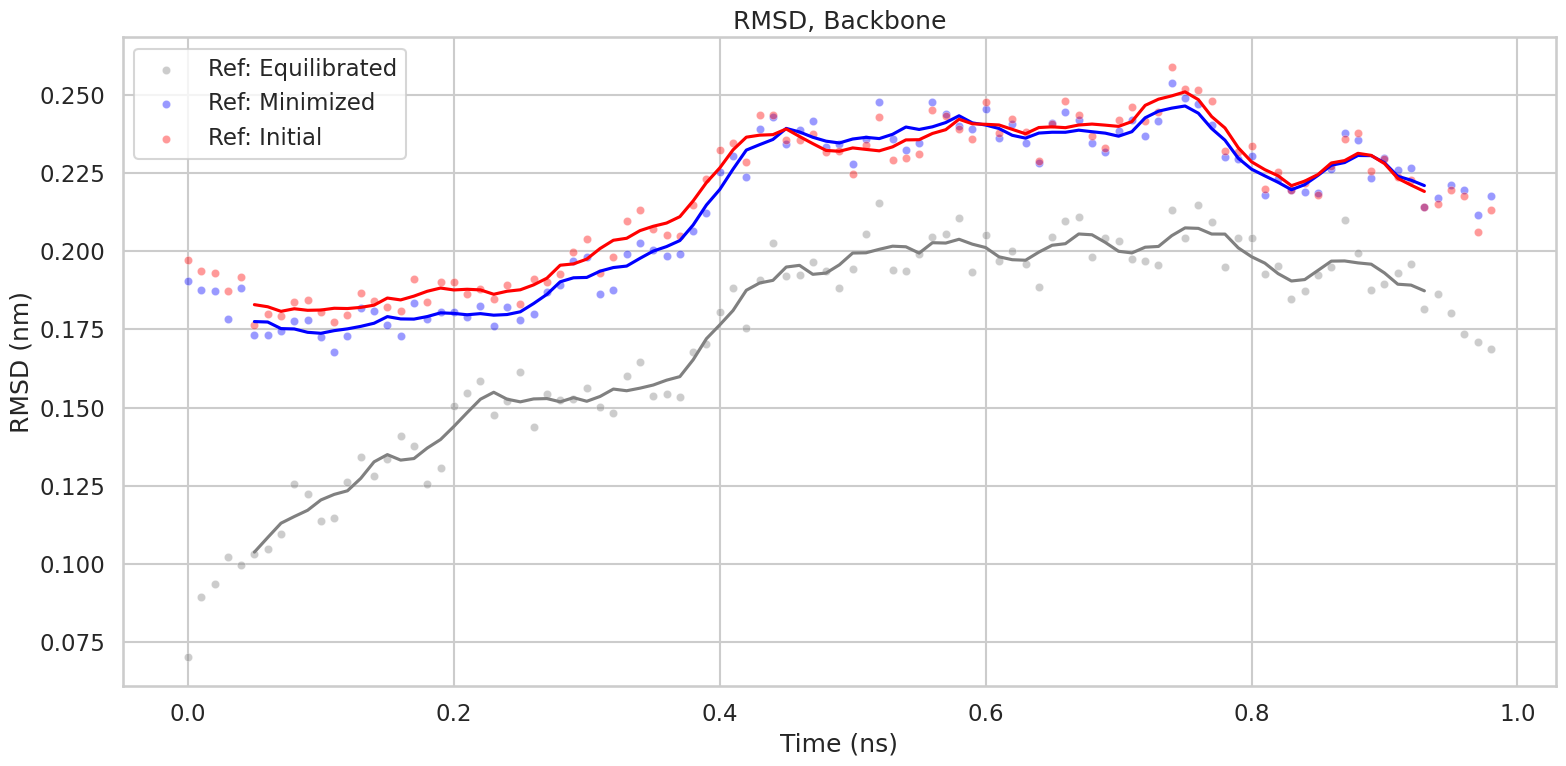

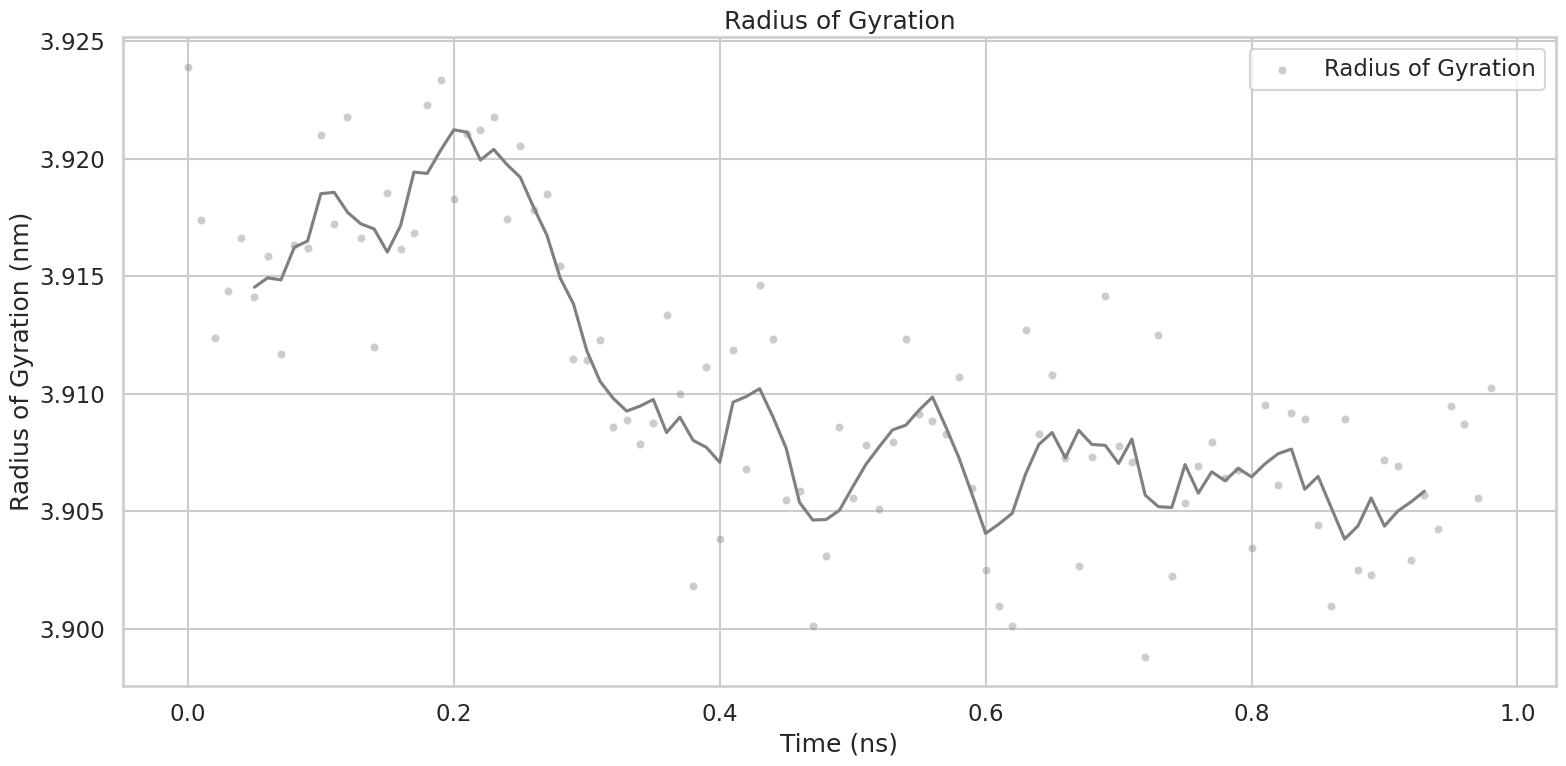

/tmp/ipykernel_152999/2123503107.py:238: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  dssp_df[col].fillna(0), np.ones(5)/5, mode="same"
/tmp/ipykernel_152999/2123503107.py:238: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  dssp_df[col].fillna(0), np.ones(5)/5, mode="same"
/tmp/ipykernel_152999/2123503107.py:238: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_do

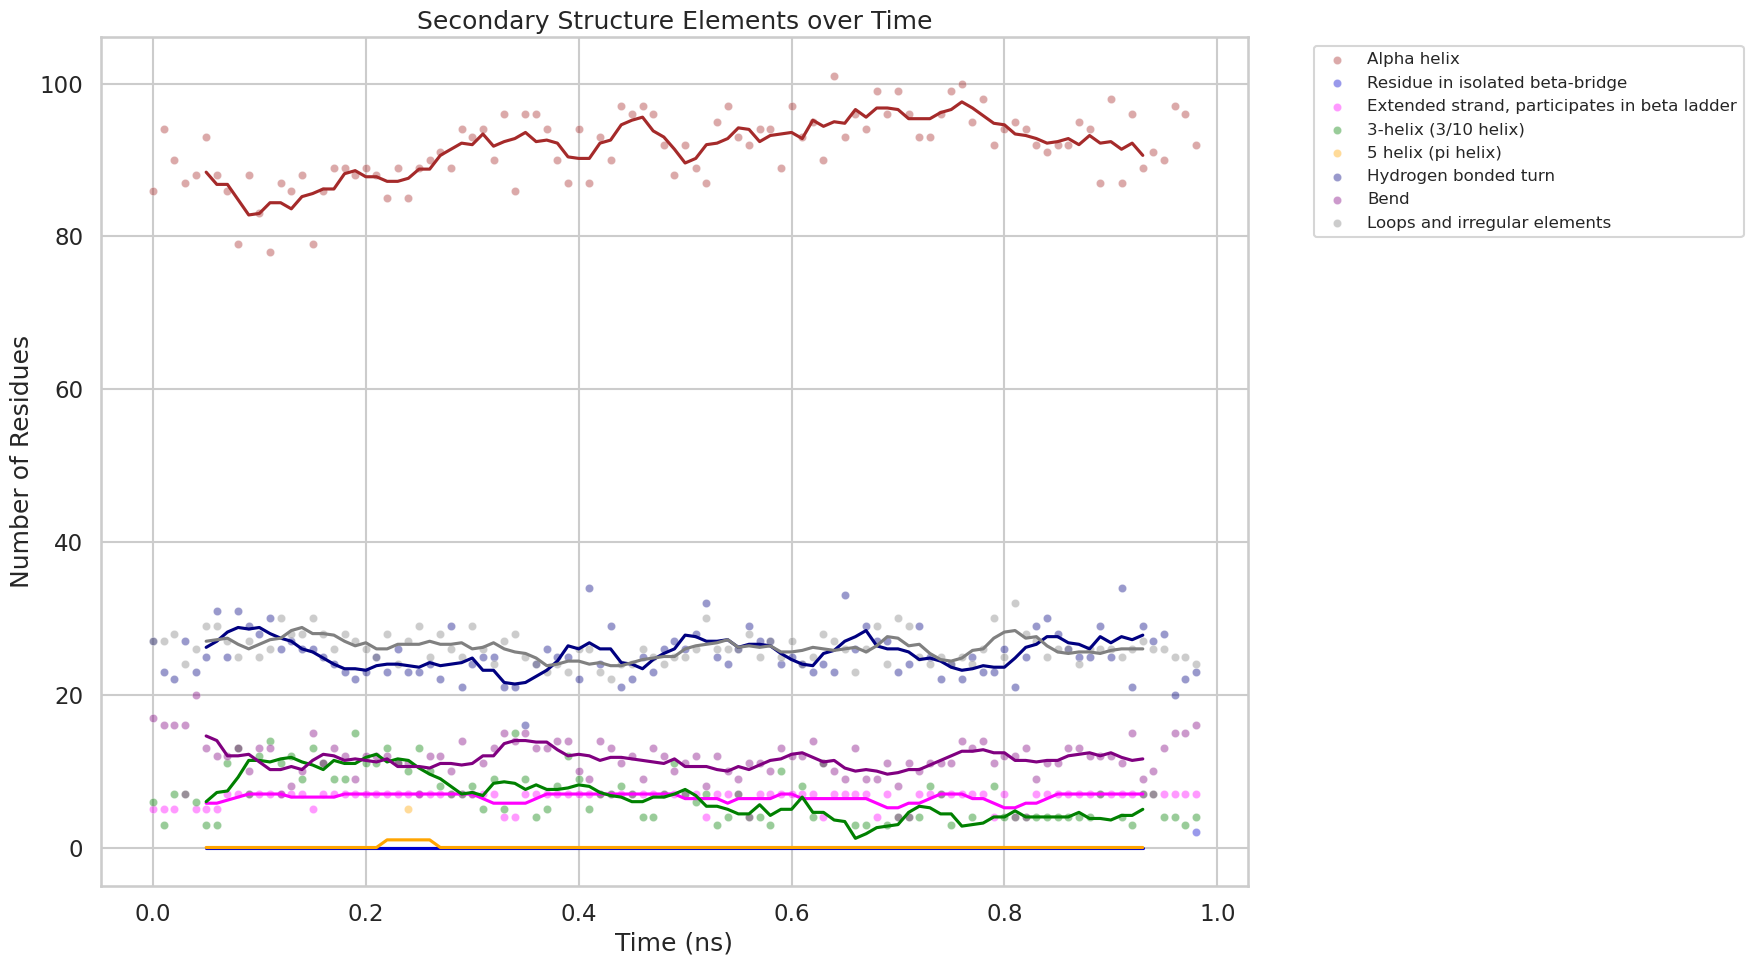

In [3]:
analysis("chimera25")

dcdplugin) detected standard 32-bit DCD file of native endianness
dcdplugin) CHARMM format DCD file (also NAMD 2.1 and later)
Plotting Production Log Data...


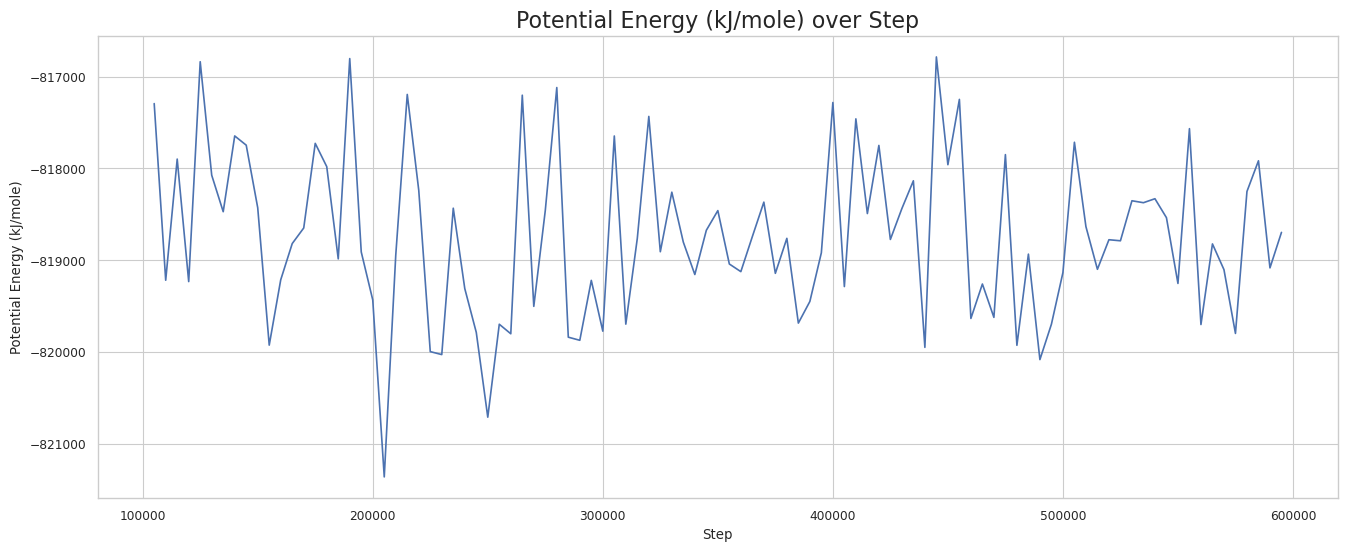

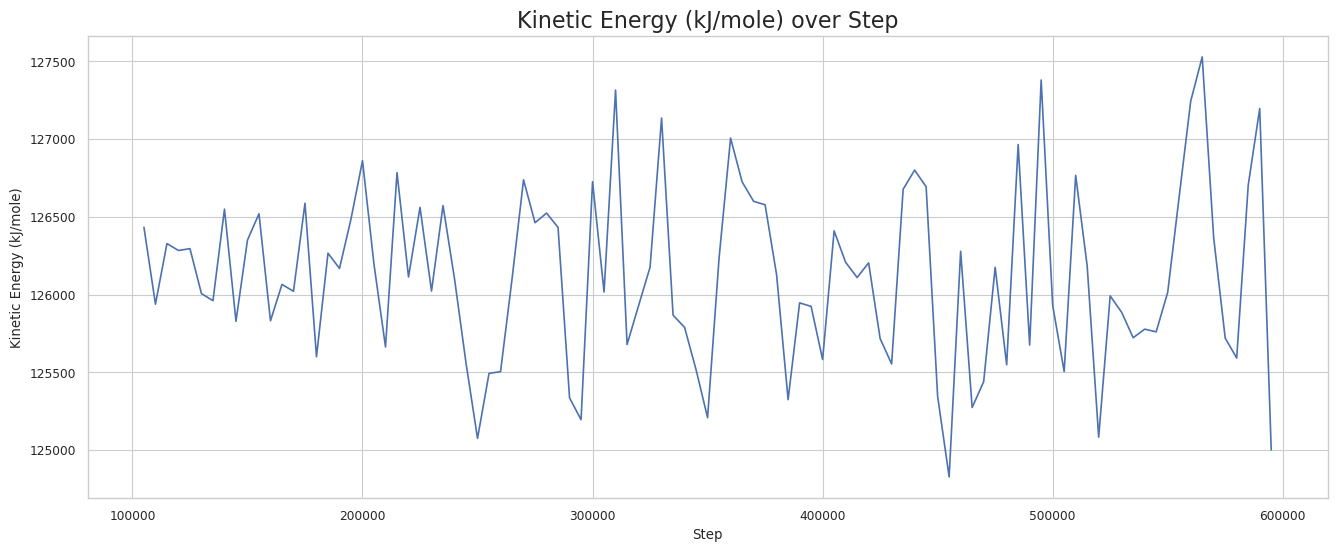

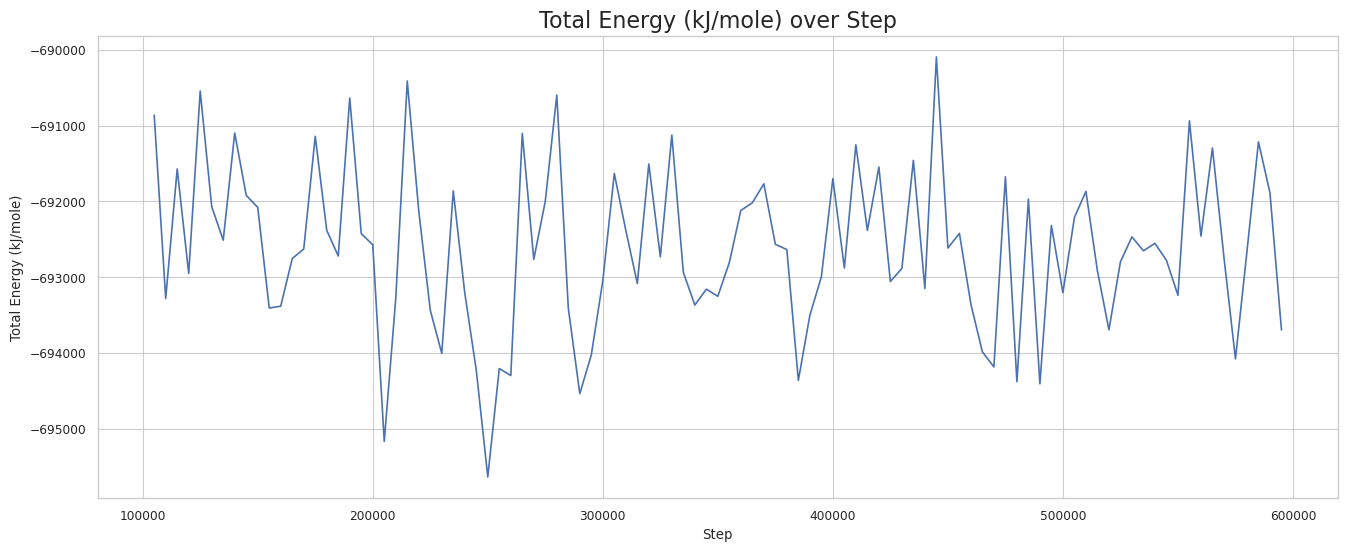

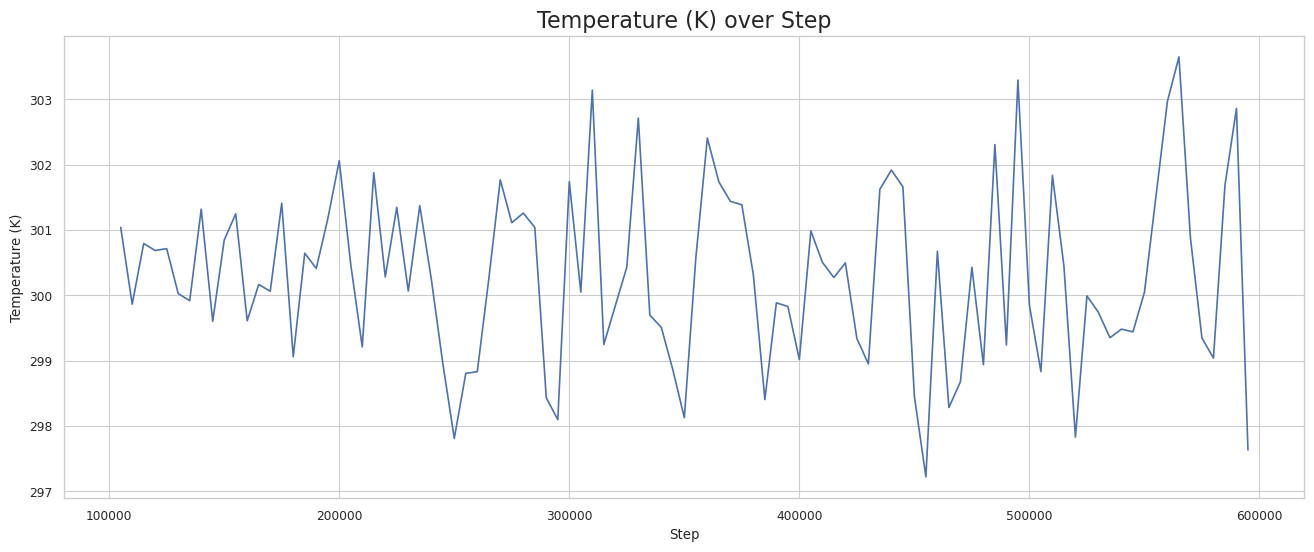

Plotting Trajectory Metrics...


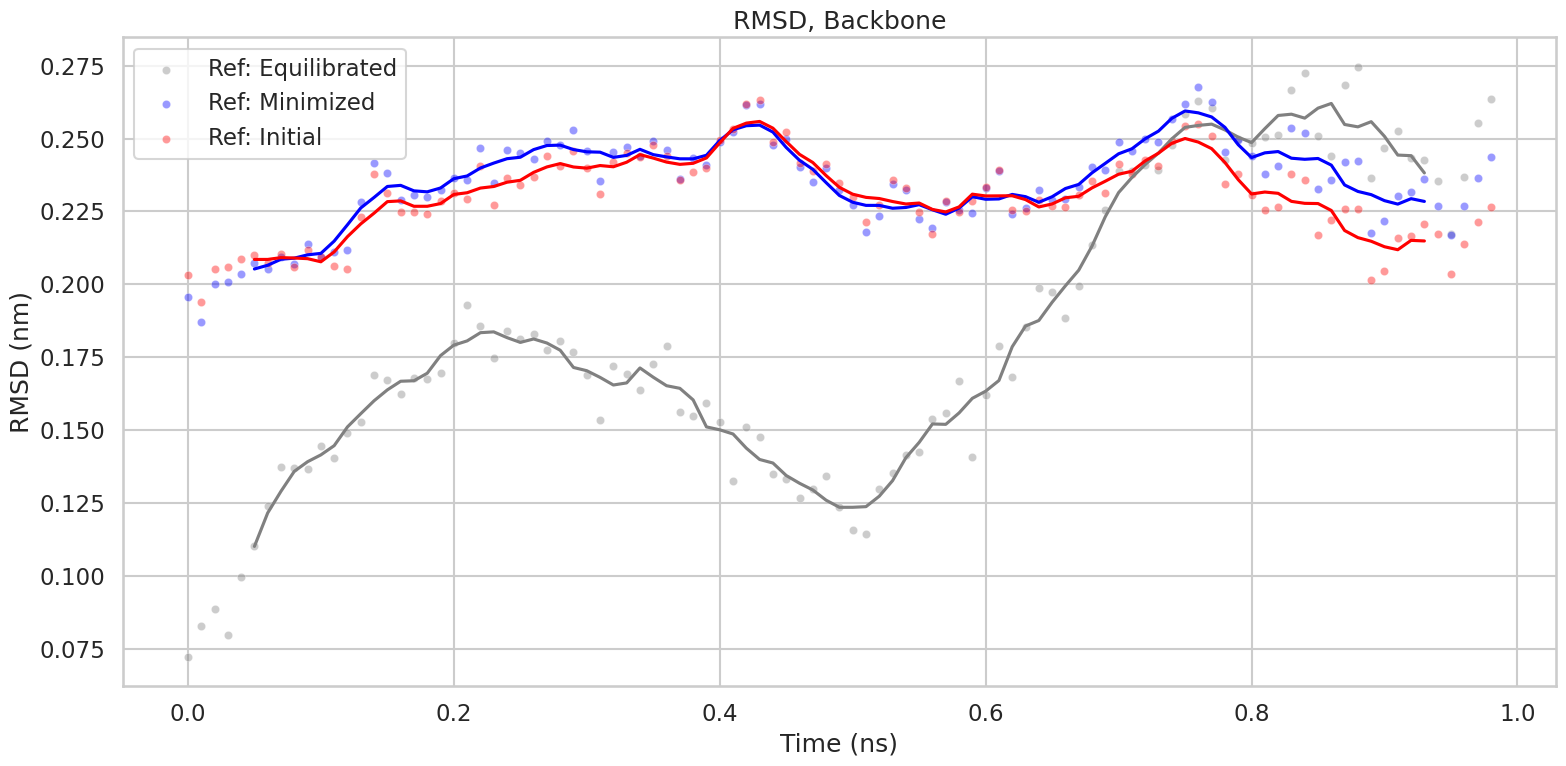

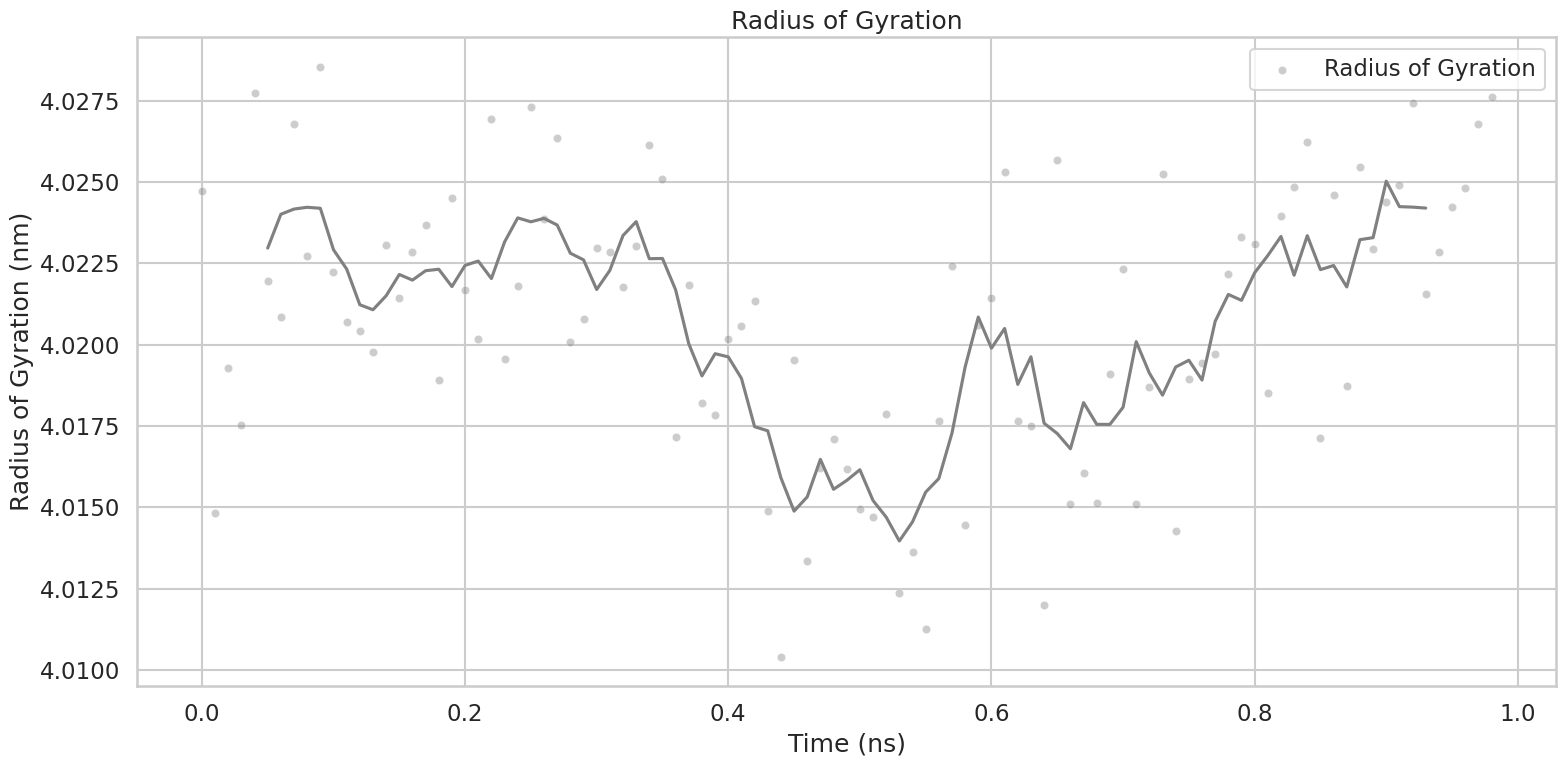

/tmp/ipykernel_152999/2123503107.py:238: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  dssp_df[col].fillna(0), np.ones(5)/5, mode="same"
/tmp/ipykernel_152999/2123503107.py:238: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  dssp_df[col].fillna(0), np.ones(5)/5, mode="same"
/tmp/ipykernel_152999/2123503107.py:238: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_do

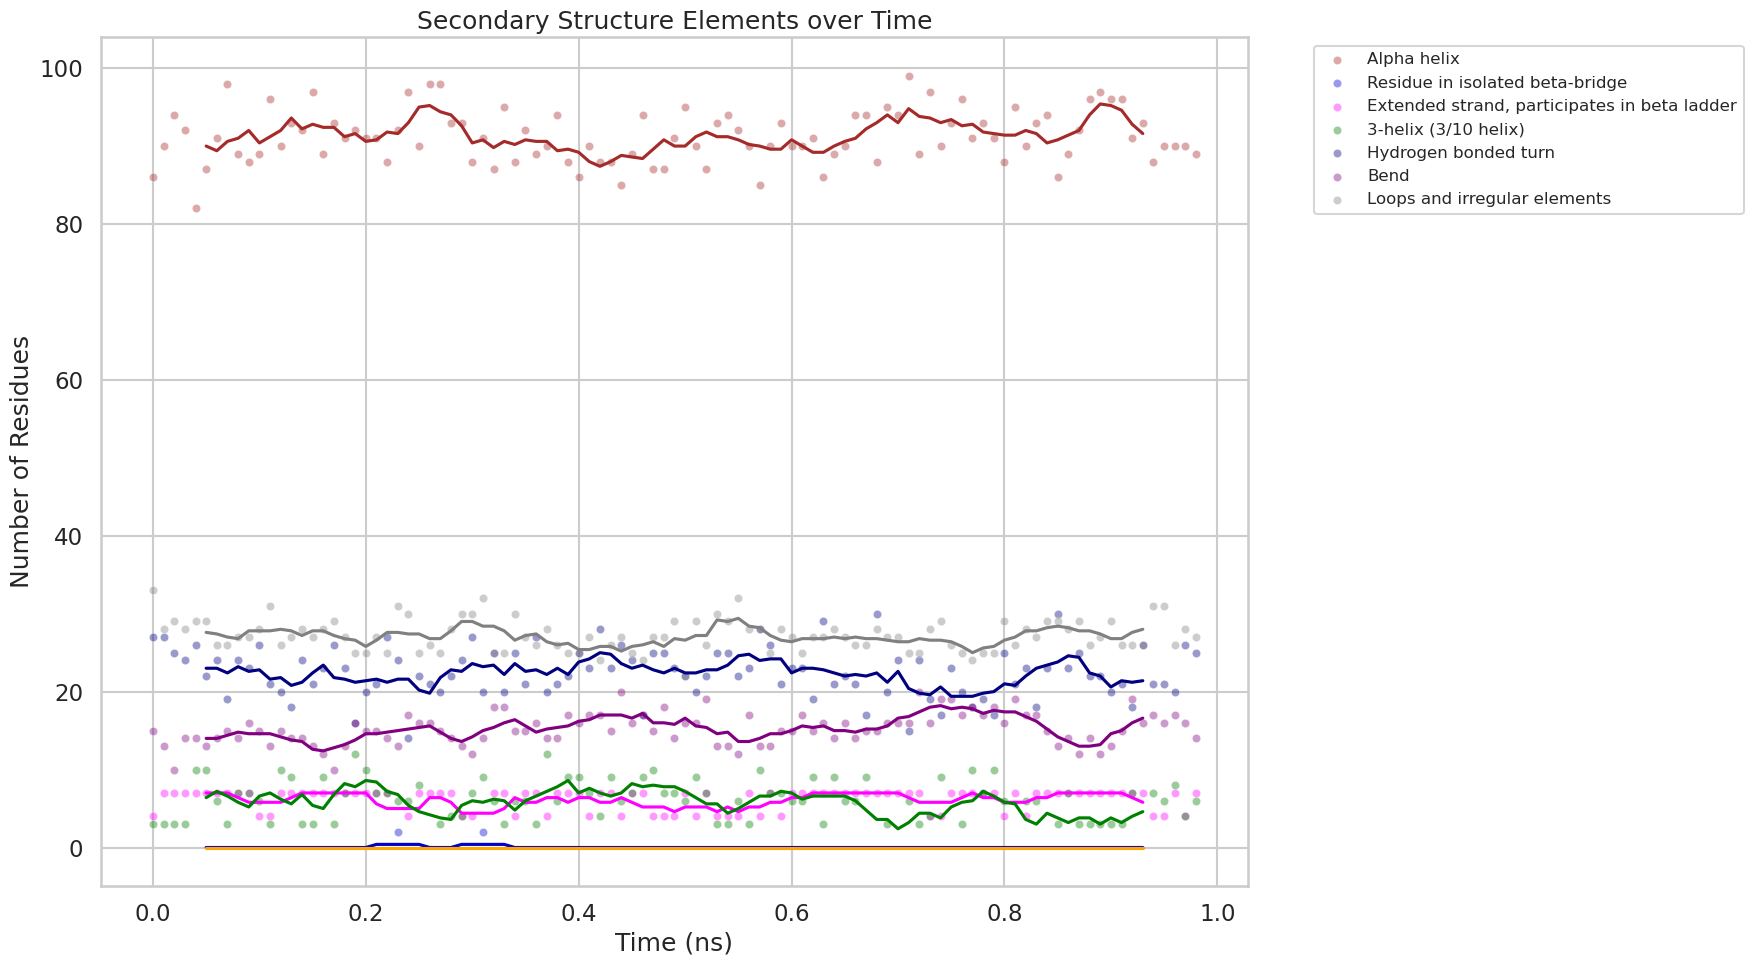

In [4]:
analysis("manually_modified")

In [4]:
traj = load_dcd(
    "manually_modified_production.dcd",
    top="manually_modified_minimized.pdb"
)

dcdplugin) detected standard 32-bit DCD file of native endianness
dcdplugin) CHARMM format DCD file (also NAMD 2.1 and later)


In [7]:
frame = 75
struct = traj[frame]
struct.save_pdb("optimal.pdb")